In [1]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet
from models.ResNet_revised import ResNet_revised
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import fbeta_score, confusion_matrix
import numpy as np
from lib.plot import plot_histogram

2024-08-21 10:52:33.412662: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 10:52:33.425551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 10:52:33.439116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 10:52:33.443156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 10:52:33.453316: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf

# GPUを無効化
tf.config.set_visible_devices([], 'GPU')

In [3]:
DATA_TYPE1 = 'gr'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleEmbedding'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
data_loader = SingleDataLoader(training_data_dir1)

In [4]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, 1)
n_base = 8
BN = True
checkpoint_dir = f'../checkpoints/valid/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base=n_base, input_shape=input_shape, learning_rate=0.0, loss=BinaryCrossentropy(), metrics=[], BN=BN)
model.load_weights(latest_checkpoint)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 21, 21,    │          0 │ -                 │
│ (InputLayer)        │ 21, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 21, 21,    │        224 │ input_layer[0][0] │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 21, 21,    │         32 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 21, 21,    │      1,736 │ activation[0][0]  │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 21, 21,    │      1,736 │ activation_1[0][… │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 21, 21,    │          0 │ batch_normalizat… │
│                     │ 21, 8)            │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 21, 21,    │          0 │ add[0][0]         │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 10, 10,    │          0 │ activation_2[0][… │
│ (MaxPooling3D)      │ 10, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 10, 10,    │      3,472 │ max_pooling3d[0]… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │         64 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 10, 10,    │      6,928 │ activation_3[0][… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 10, 10,    │        144 │ max_pooling3d[0]

 Total params: 58,081 (226.88 KB)

 Trainable params: 57,745 (225.57 KB)

 Non-trainable params: 336 (1.31 KB)

/home/ito/research/src/yuki_research/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
threshold = 0.45

In [7]:
data_dir = '../../data'
test_list = os.path.join(data_dir, 'valid_test.txt')
with open(test_list, 'r') as f:
    test_pdb_array = f.read().splitlines()
cm_for_each_pdb = {}
accuracy_for_each_pdb = {}
recall_for_each_pdb = {}
precision_for_each_pdb = {}
specificity_for_each_pdb = {}
negative_precision_for_each_pdb = {}

for pdb in test_pdb_array:
    print(pdb)
    test_data, test_data_label = data_loader.load_data_with_pdb_array([pdb])
    prediction = model.predict(test_data)
    prediction_values = prediction.reshape(prediction.shape[0])
    predicted_label = custom_threshold(prediction, threshold)
    cm1 = confusion_matrix(test_data_label, predicted_label)
    cm_for_each_pdb[pdb] = cm1

    # Recall (Sensitivity, True Positive Rate)
    recall_for_each_pdb[pdb] = cm1[1, 1] / (cm1[1, 1] + cm1[1, 0]) if (cm1[1, 1] + cm1[1, 0]) != 0 else 0

    # Precision (Positive Predictive Value)
    precision_for_each_pdb[pdb] = cm1[1, 1] / (cm1[1, 1] + cm1[0, 1]) if (cm1[1, 1] + cm1[0, 1]) != 0 else 0

    # Negative Predictive Value (NPV)
    negative_precision_for_each_pdb[pdb] = cm1[0, 0] / (cm1[0, 0] + cm1[1, 0]) if (cm1[0, 0] + cm1[1, 0]) != 0 else 0

    # Accuracy
    accuracy_for_each_pdb[pdb] = (cm1[0, 0] + cm1[1, 1]) / np.sum(cm1) if np.sum(cm1) != 0 else 0

    # Specificity (True Negative Rate)
    specificity_for_each_pdb[pdb] = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1]) if (cm1[0, 0] + cm1[0, 1]) != 0 else 0


1adl


I0000 00:00:1724205245.935857 2054865 service.cc:146] XLA service 0x14b1ec011770 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724205245.935898 2054865 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-21 10:54:05.947393: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724205246.119936 2054865 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1bju
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1bjv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1bty
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1bxr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1bzy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1c1r
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1c5p
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1c5q
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1c5s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1c5t
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1eb2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1erb
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1f0t
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1f0u
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1g36
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1g3d
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1g3e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1g74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1ghz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1gi1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1gi4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1gj6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

In [8]:
accuracy_for_each_pdb_np = np.array(list(accuracy_for_each_pdb.values()))
recall_for_each_pdb_np = np.array(list(recall_for_each_pdb.values()))
precision_for_each_pdb_np = np.array(list(precision_for_each_pdb.values()))
specificity_for_each_pdb_np = np.array(list(specificity_for_each_pdb.values()))
negative_precision_for_each_pdb_np = np.array(list(negative_precision_for_each_pdb.values()))

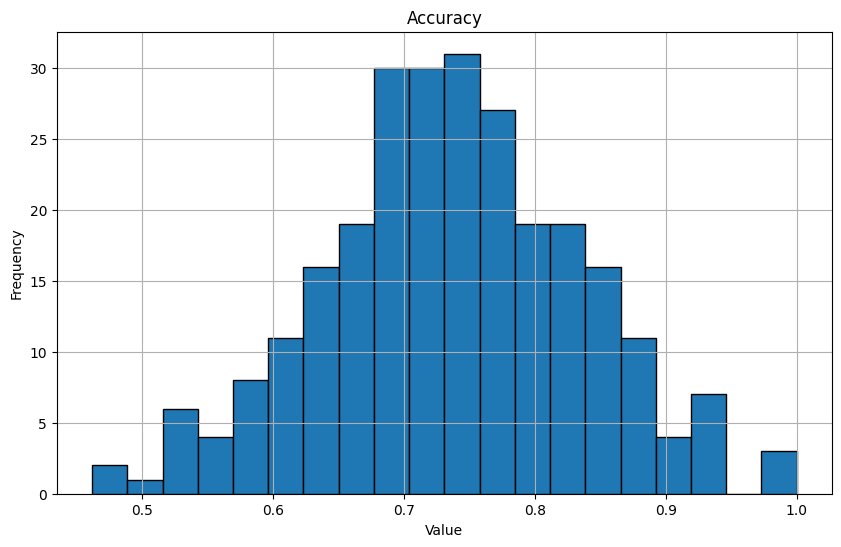

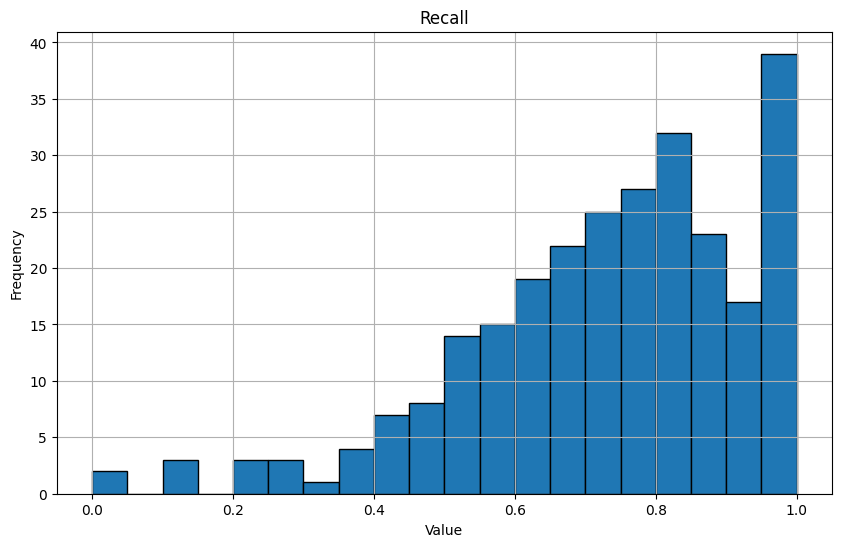

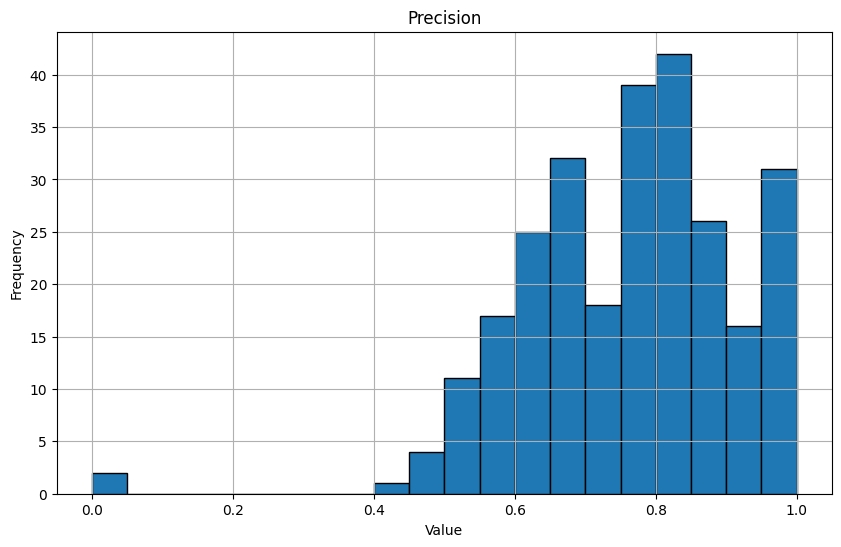

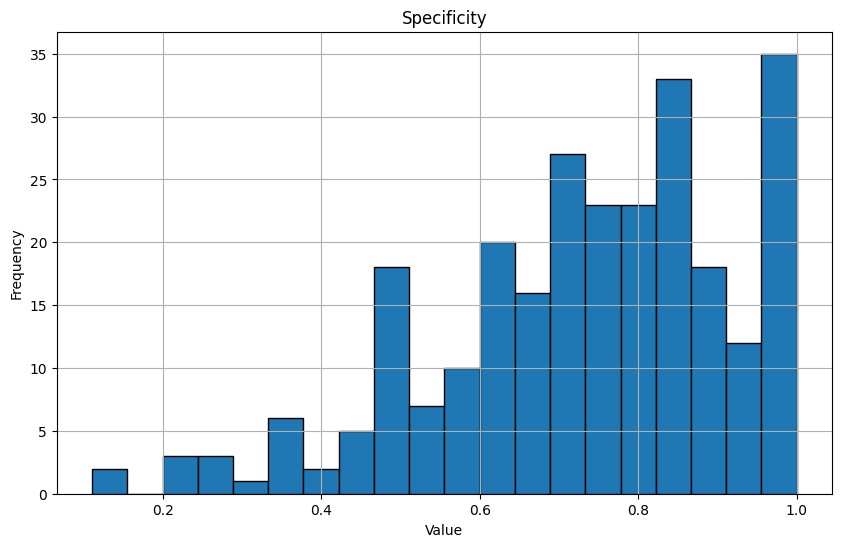

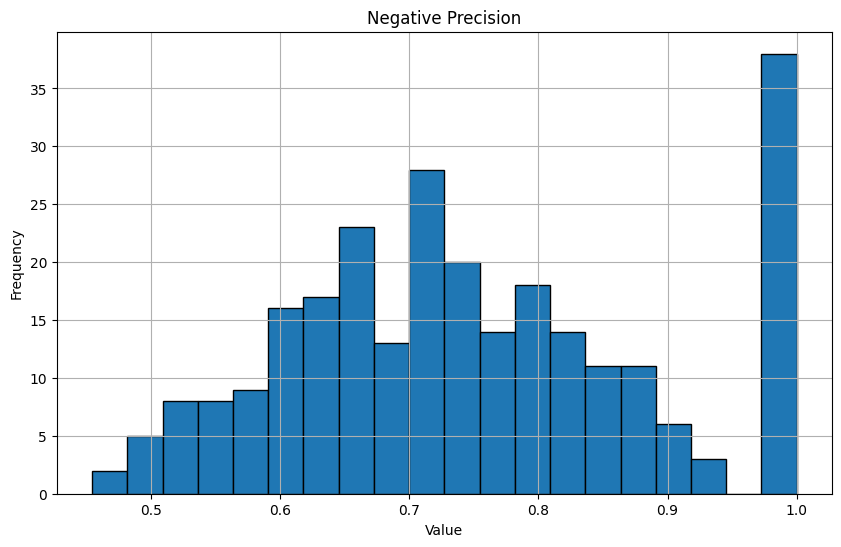

In [9]:
plot_histogram(accuracy_for_each_pdb_np, bins=20, title='Accuracy')
plot_histogram(recall_for_each_pdb_np, bins=20, title='Recall')
plot_histogram(precision_for_each_pdb_np, bins=20, title='Precision')
plot_histogram(specificity_for_each_pdb_np, bins=20, title='Specificity')
plot_histogram(negative_precision_for_each_pdb_np, bins=20, title='Negative Precision')

In [13]:
i = 3
under_threshold = 0.9
threshold = 1.1

accuracy_under_threshold = accuracy_for_each_pdb_np[(accuracy_for_each_pdb_np >= under_threshold) & (accuracy_for_each_pdb_np < threshold)]
indices = np.where((accuracy_for_each_pdb_np >= under_threshold) & (accuracy_for_each_pdb_np < threshold))[0]
print(np.array(test_pdb_array)[indices])
pdb = test_pdb_array[indices[i]]
print(accuracy_under_threshold)
print(cm_for_each_pdb[pdb])

['1erb' '1gi4' '1tng' '1v0l' '2bza' '2w66' '2wvt' '2zft' '3gy4' '3nyx'
 '3o75' '4abh' '4io7']
[0.92857143 0.90909091 0.92857143 1.         0.92307692 0.92307692
 1.         0.91428571 1.         0.91428571 0.92857143 0.93333333
 0.92307692]
[[ 9  0]
 [ 0 12]]


In [14]:
i = 5
under_threshold = 0.4
threshold = 0.5

recall_under_threshold = recall_for_each_pdb_np[(recall_for_each_pdb_np >= under_threshold) & (recall_for_each_pdb_np < threshold)]
indices = np.where((recall_for_each_pdb_np >= under_threshold) & (recall_for_each_pdb_np < threshold))[0]
print(np.array(test_pdb_array)[indices])
pdb = test_pdb_array[indices[i]]
print(recall_under_threshold)
print(cm_for_each_pdb[pdb])

['1g36' '1g74' '1k1l' '1k1n' '1m48' '1ppc' '1pph' '1y3v' '2hxm' '3hww'
 '3s8o' '4daf' '4db7' '4gih' '4gj3']
[0.44444444 0.4        0.4        0.44444444 0.47058824 0.45
 0.42857143 0.45       0.47058824 0.42857143 0.46666667 0.45454545
 0.41666667 0.47058824 0.46666667]
[[14  6]
 [11  9]]


In [10]:
i = 0
threshold = 0.4

specificity_under_threshold = specificity_for_each_pdb_np[specificity_for_each_pdb_np < threshold]
indices = np.where((specificity_for_each_pdb_np < threshold))[0]
print(np.array(test_pdb_array)[indices])
pdb = test_pdb_array[indices[i]]
print(specificity_under_threshold)
print(cm_for_each_pdb[pdb])

['1adl' '1hms' '1qkt' '1tnh' '1v2u' '2vl4' '2vmf' '2vot' '2vqt' '2xib'
 '3hmp' '3tzm' '4mss' '4pb2' '4y3j' '4y3y']
[0.38461538 0.33333333 0.33333333 0.33333333 0.25       0.2
 0.25       0.11111111 0.375      0.14285714 0.23529412 0.30769231
 0.28571429 0.23076923 0.33333333 0.33333333]
[[ 5  8]
 [ 1 16]]


In [1]:
import shutil

# コピー元のファイルパス
pdb = '4pb2'
source_file1 = f'/mnt/dandan/3drism/dir_3DRISM_20181213_155211/{pdb}/{pdb}_min.pdb'
source_file2 = f'/mnt/dandan/3drism/dir_3DRISM_20181213_155211/{pdb}/{pdb}_ligand.pdb'

# コピー先のディレクトリ
destination_directory = '/home/ito/research/'

# ファイルをコピー
shutil.copy(source_file1, destination_directory)
shutil.copy(source_file2, destination_directory)

print("ファイルのコピーが完了しました。")


ファイルのコピーが完了しました。
